<a href="https://colab.research.google.com/github/haleema1011/AI_Flood_Warning_Nothern_Pakistan/blob/main/Multistep_forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install tensorflow[complete]
!pip install scikeras


## Import all the necessary libraries

In [ ]:
!pip install scikit_learn==1.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: scikit_learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.29.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
import pandas as pd
import requests
from io import StringIO
import ee
import tensorflow as tf
from keras import models, optimizers, layers, callbacks, backend as K
from sklearn import preprocessing
from datetime import datetime
import folium
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
# from keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [ ]:
model_df = pd.read_csv("/content/kabul_river_met_discharge_data.csv")

In [ ]:
model_df

,Date,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
0,2005-01-01,2005.0,1.0,-0.576,-6.148,3.240,86.145,2.161,728.1
1,2005-01-02,2005.0,2.0,-0.795,-6.936,2.980,81.400,1.530,792.0
2,2005-01-03,2005.0,3.0,2.891,-8.300,2.612,68.630,0.015,514.3
3,2005-01-04,2005.0,4.0,2.906,-6.894,2.607,67.174,0.021,415.1
4,2005-01-05,2005.0,5.0,3.171,-8.099,2.550,69.000,0.097,390.6
...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,2020.0,362.0,-3.808,-12.403,2.210,78.062,0.346,223.2
5840,2020-12-28,2020.0,363.0,-1.672,-12.619,2.046,73.555,0.017,249.5
5841,2020-12-29,2020.0,364.0,1.629,-13.475,1.660,57.732,0.000,255.6
5842,2020-12-30,2020.0,365.0,3.207,-11.469,1.531,46.392,0.028,260.5


# Convert 'date' to datetime and set as index

In [ ]:
model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df.set_index('Date', inplace=True)

In [ ]:
model_df.head()

,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
Date,,,,,,,,
2005-01-01,2005.0,1.0,-0.576,-6.148,3.240,86.145,2.161,728.1
2005-01-02,2005.0,2.0,-0.795,-6.936,2.980,81.400,1.530,792.0
2005-01-03,2005.0,3.0,2.891,-8.300,2.612,68.630,0.015,514.3
2005-01-04,2005.0,4.0,2.906,-6.894,2.607,67.174,0.021,415.1
2005-01-05,2005.0,5.0,3.171,-8.099,2.550,69.000,0.097,390.6


**Loss and Metrics:** The build_model function  uses 'huber_loss' for the loss and includes 'mae', 'mse', and 'mape' as metrics. below is the explanation of those.  
**Evaluation:** The evaluation step captures the Huber loss, MAE, MSE, and MAPE.
<br><br>
* **mean absolute percentage error (MAPE):** is the percentage equivalent of mean absolute error (MAE). $$ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$

* **Root Mean Squared Error (RMSE):**   $$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

* **Mean Absolute Error (MAE):** $$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i | $$

**Huber loss** is a loss function used in robust regression that is less sensitive to outliers than the squared error loss. It combines the best properties of both the Mean Squared Error (MSE) and Mean Absolute Error (MAE). The Huber loss is quadratic for small errors and linear for large errors. This makes it more robust to outliers in data compared to the MSE.

The formula for the Huber loss is defined as follows:
$$
L_\delta(a) =
\begin{cases}
\frac{1}{2}a^2 & \text{for } |a| \leq \delta \\
\delta(|a| - \frac{1}{2}\delta) & \text{for } |a| > \delta
\end{cases}
$$
Where:   
* $a = y_i - \hat{y}_i$
is the difference between the actual value and the predicted value.  
* $ \delta $ is a threshold parameter that determines the point where the loss function changes from quadratic to linear.
* The Huber loss is particularly useful when you have data with outliers, as it minimizes the impact of these outliers on the model.

<Axes: xlabel='Date'>

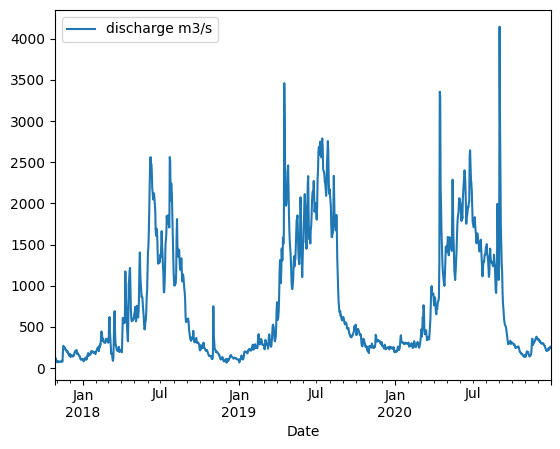

In [ ]:
model_df[-1162:].plot(y = 'discharge m3/s', use_index=True)

In [ ]:
# Split data into training and testing sets
test_split = round(len(model_df) * 0.20)

df_for_training = model_df[:-test_split]

df_for_testing = model_df[-test_split:]

print(df_for_training.shape)
print(df_for_testing.shape)

# Scale the data
scaler = RobustScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

(4675, 8)
(1169, 8)


In [ ]:
df_for_testing.describe()

,YEAR,DOY,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,discharge m3/s
count,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000,1169.000000
mean,2018.875962,192.273738,14.949490,1.967625,5.051454,54.702356,1.575010,768.202917
std,0.927609,108.216086,9.216248,7.742777,2.500846,16.310297,4.239156,722.596614
min,2017.000000,1.000000,-3.808000,-16.670000,0.897000,16.424000,0.000000,64.800000
25%,2018.000000,98.000000,7.049000,-4.553000,2.862000,42.461000,0.000000,236.000000
50%,2019.000000,195.000000,15.298000,2.738000,4.638000,52.070000,0.137000,371.300000
75%,2020.000000,293.000000,23.540000,8.761000,7.037000,66.489000,1.275000,1291.000000
max,2020.000000,366.000000,31.302000,15.826000,11.249000,92.456000,71.426000,4145.000000


In [ ]:
# Create sequences for multistep forecasting
def generate_multistep_sequences(data, look_back_period, forecast_horizon):
    X, Y = [], []
    for index in range(look_back_period, len(data) - forecast_horizon + 1):
        X.append(data[index - look_back_period:index, :])  # Input sequence
        Y.append(data[index:index + forecast_horizon, -1])  # Target sequence for multiple steps ahead
    return np.array(X), np.array(Y)

# Defining the number of steps for past inputs and future outputs
look_back_period = 20  # Number of past observations to use as input
forecast_horizon = 5   # Number of future steps to predict

# Creating sequences for training and testing datasets
train_features, train_targets = generate_multistep_sequences(df_for_training_scaled, look_back_period, forecast_horizon)
test_features, test_targets = generate_multistep_sequences(df_for_testing_scaled, look_back_period, forecast_horizon)

# Shapes of the resulting features and targets
print(f"Train Features Shape: {train_features.shape}")  # Expected: (samples, look_back_period, features)
print(f"Train Targets Shape: {train_targets.shape}")    # Expected: (samples, forecast_horizon)


Train Features Shape: (4651, 20, 8)
Train Targets Shape: (4651, 5)


In [ ]:
# Build the model
def build_model(optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(30, train_features.shape[2])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(forecast_horizon))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae', 'mse', 'mape'])
    return model

# Wrapping the build_model function
grid_model = KerasRegressor(build_model, verbose=1)

# Define the grid search parameters
parameters = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2)

# Fit the model and capture the training history
history = grid_search.fit(train_features, train_targets, validation_data=(test_features, test_targets))

# Print the best parameters and score
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")



Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0855 - mae: 0.2905 - mape: 213.1061 - mse: 0.1828 - val_loss: 0.0402 - val_mae: 0.1720 - val_mape: 74.6213 - val_mse: 0.0891
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0318 - mae: 0.1627 - mape: 183.5872 - mse: 0.0656 - val_loss: 0.0369 - val_mae: 0.1666 - val_mape: 72.7628 - val_mse: 0.0822
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0264 - mae: 0.1476 - mape: 132.6294 - mse: 0.0543 - val_loss: 0.0426 - val_mae: 0.1769 - val_mape: 64.1799 - val_mse: 0.0938
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0212 - mae: 0.1331 - mape: 130.4478 - mse: 0.0429 - val_loss: 0.0329 - val_mae: 0.1626 - val_mape: 92.4532 - val_mse: 0.0716
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0197 - mae: 0.1246 - mape: 151.3429 - mse: 0.0404 - val_loss: 0.0312 - val_mae: 0.1519 - val_mape: 70.6365 - val_mse: 0.0691
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss:

In [ ]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set using the best model (multistep forecasting)
test_predictions = best_model.predict(test_features)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set using the best model (multistep forecasting)
test_predictions_scaled = best_model.predict(test_features)

# Inverse scaling of the predictions and targets using the original scaler

# Initialize an empty array to store the inverse-transformed predictions
test_predictions_inversed = np.zeros_like(test_predictions_scaled)

# Reshape test_predictions_scaled to a 2D array for inverse_transform
test_predictions_scaled_2d = test_predictions_scaled.reshape(-1, test_predictions_scaled.shape[-1])

# Inverse transform using a scaler fitted on the target variable only
test_predictions_inversed = scaler.inverse_transform(
    np.concatenate(
        [
            np.zeros((test_predictions_scaled_2d.shape[0], df_for_training_scaled.shape[1] - forecast_horizon)),
            test_predictions_scaled_2d
        ],
        axis=1,
    )
)[:, -forecast_horizon:]

# Reshape test_targets to a 2D array for inverse_transform
test_targets_2d = test_targets.reshape(-1, test_targets.shape[-1])

# Inverse transform using a scaler fitted on the target variable only
test_targets_inversed = scaler.inverse_transform(
    np.concatenate(
        [
            np.zeros((test_targets_2d.shape[0], df_for_training_scaled.shape[1] - forecast_horizon)),
            test_targets_2d,
        ],
        axis=1,
    )
)[:, -forecast_horizon:]

In [ ]:


# Initialize lists to store errors per forecast day (step)
mae_per_day = []
mse_per_day = []
rmse_per_day = []
r2_per_day = []

# Loop through each forecast day (step) in the forecast horizon
for day in range(forecast_horizon):
    # Extract the predictions and true values for this day
    predicted_values = test_predictions_inversed[:, day]
    actual_values = test_targets_inversed[:, day]

    # Calculate the error metrics for this day
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_values, predicted_values)

    # Store the errors
    mae_per_day.append(mae)
    mse_per_day.append(mse)
    rmse_per_day.append(rmse)
    r2_per_day.append(r2)

# Display the results
print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")
print("Performance per forecast day:")

for day in range(forecast_horizon):
    print(f"Day {day+1}:")
    print(f"  MAE: {mae_per_day[day]}")
    print(f"  MSE: {mse_per_day[day]}")
    print(f"  RMSE: {rmse_per_day[day]}")
    print(f"  R^2: {r2_per_day[day]}")

# Optionally: Track how many days the model is forecasting well (below a threshold)
threshold = 10  # for example, an MAE threshold of 10
days_above_threshold = sum(np.array(mae_per_day) < threshold)

print(f"\nModel is forecasting well (MAE < {threshold}) for {days_above_threshold} days.")

Best: 0.843817196845611 using {'batch_size': 32, 'epochs': 10, 'optimizer': 'adam'}
Performance per forecast day:
Day 1:
  MAE: 1.3855989081313134
  MSE: 4.984991790775435
  RMSE: 2.2327095177777685
  R^2: 0.9378039527469055
Day 2:
  MAE: 0.4447174390083952
  MSE: 0.6025310088103932
  RMSE: 0.7762287090866926
  R^2: 0.9128068372279918
Day 3:
  MAE: 2.8412034290399015
  MSE: 26.026081104606195
  RMSE: 5.101576335271893
  R^2: 0.8822302829041668
Day 4:
  MAE: 0.19546592985219446
  MSE: 0.11451677677048129
  RMSE: 0.33840327535424547
  R^2: 0.8614094084860131
Day 5:
  MAE: 171.53389736544145
  MSE: 86133.30298404358
  RMSE: 293.4847576690203
  R^2: 0.8357675403166624

Model is forecasting well (MAE < 10) for 4 days.


In [ ]:
# prompt: create a table of each day prediction

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Day': range(1, forecast_horizon + 1),
    'MAE': mae_per_day,
    'MSE': mse_per_day,
    'RMSE': rmse_per_day,
    'R^2': r2_per_day
})

# Display the table
results_df

,Day,MAE,MSE,RMSE,R^2
0,1,1.385599,4.984992,2.232710,0.937804
1,2,0.444717,0.602531,0.776229,0.912807
2,3,2.841203,26.026081,5.101576,0.882230
3,4,0.195466,0.114517,0.338403,0.861409
4,5,171.533897,86133.302984,293.484758,0.835768


In [ ]:
# prompt: overall results of model

# Display the overall results in a more user-friendly format.
print("\nOverall Model Performance Summary:")
print("-" * 40)
print(f"Best Score (GridSearchCV): {grid_search.best_score_}")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print("-" * 40)
print(results_df) # This will show the day wise results
print("-" * 40)
print(f"Days with MAE below threshold ({threshold}): {days_above_threshold} out of {forecast_horizon}")


Overall Model Performance Summary:
----------------------------------------
Best Score (GridSearchCV): 0.843817196845611
Best Hyperparameters: {'batch_size': 32, 'epochs': 10, 'optimizer': 'adam'}
----------------------------------------
   Day         MAE           MSE        RMSE       R^2
0    1    1.385599      4.984992    2.232710  0.937804
1    2    0.444717      0.602531    0.776229  0.912807
2    3    2.841203     26.026081    5.101576  0.882230
3    4    0.195466      0.114517    0.338403  0.861409
4    5  171.533897  86133.302984  293.484758  0.835768
----------------------------------------
Days with MAE below threshold (10): 4 out of 5
